In [258]:
import os
import requests 
import time
import string
import networkx as nx
import itertools
import networkx as nx
import pandas as pd
import json
import re
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords

from nltk.corpus import wordnet as wn #importing it
from nltk.stem.wordnet import WordNetLemmatizer #importing wordnet lemmatizer
from nltk import pos_tag #part-of-speech-tagger
from collections import defaultdict #defaultdict returns default value for non-existant keys you try to  access based on the function you passed in the constructor
from google.colab import files

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
def extract_text(df):     # extract the text from the tweets
  list_strings = []
  for index in range(len(df)):
    string = (df.loc[index]['extended_tweet'])
    
    if type(string) == str :
      if re.search(':(.+?)https',string):
        s = re.search(':(.+?)https',string).group(1)
        list_strings.append(s)

    else:
      list_strings.append(df.loc[index]['text'])

  return list_strings

In [114]:
def frequency_dictionary(df):
  unique_words = {}

  for row in df:
    for word in row.split():
      #if the word is encountered for the first time add to dict as key and set its value to 0
      unique_words.setdefault(word,0)
      #increase the value (i.e the count) of the word by 1 every time it is encountered
      unique_words[word] += 1

  return unique_words

In [169]:
# Cleaning, lemmatising and pos tagging tweets

nltk.download('words')
WORDS = set(nltk.corpus.words.words()) #the last two lines serve to download the corpus of standard English language words
nltk.download('stopwords') #downloading stopwords
STOP_WORDS = set(nltk.corpus.stopwords.words("english")) #taking the stop words from English language
nltk.download('wordnet') #downloading wordnet
nltk.download('averaged_perceptron_tagger') #downloading tagger
tag_map = defaultdict(lambda : wn.NOUN) #here we define that wn.NOUN is the default value for the dict
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

def lemma_pos_cleaner(tweet):

    tweet = re.sub("@[A-Za-z0-9]+","",tweet) # remove mentions
    tweet = re.sub("#[A-Za-z0-9]+", "",tweet) # remove hashtags
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) # remove http links
    tweet = " ".join(tweet.split())
    tweet = str.lower(tweet) #to lowercase 
    tweet = re.sub("'"," ",tweet) # remove aphostrophe

    #basically we use pos_tag function on tokens that we get by applying wordpunct tokenization
    #to tweet (it separates all the words and symbols)
    #then we pass the token along with it's wordnet pos value that we get from the tag_map dictionary (noun, adjective, verb or adverb) to the lemma function (the WordNetLemmatizer())
    lemma_function = WordNetLemmatizer()
    tweet = " ".join(lemma_function.lemmatize(token, tag_map[tag[0]]) for token, tag in nltk.pos_tag(nltk.wordpunct_tokenize(tweet))) #lemmatize

    # francesco: I removed also all 2 letters words and added specific words, words that appears frequently but are discarded because they are not in the english language
    SPECIFIC_WORDS = ['virus', 'coronavirus', 'covid19', 'covid', 'trump', 'hubei', 'beijing', 'xinjiang', 'jinping', 'korea', 'xinhua', 'india', 'taiwan','johnson','singapore', 'africa', 'japanese', 'france', 'asian', 'australia', 'french', 'asia', 'leishenshan', 'british', 'qingdao', 'fauci', 'america',  'california', 'sichuan', 'malaysia', 'huawei','thailand', 'shandong', 'italy', 'philippines', 'germany', 'facebook', 'african', 'shenzhen', 'tokyo', 'russian','uygur', '5g', 'pompeo', 'vietnam', 'australian', 'cambodia', 'zhejiang', 'yunnan', 'guangdong', 'korean', 'iran', 'washington']
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) if (w in WORDS or w in SPECIFIC_WORDS) and len(w)>2 and w not in STOP_WORDS ) #remove stop words
   
    return tweet

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [118]:
China_USA = pd.read_csv('/content/China&USA.csv')
China_USA = China_USA.sort_values(by="retweet_count", ascending = False)

# number of tweets:
len(China_USA)

31796

In [ ]:
China_USA_text = extract_text(China_USA)

In [ ]:
cleaned_China_USA_text = [lemma_pos_cleaner(txt) for txt in China_USA_text]

In [217]:
freq_dict = frequency_dictionary(cleaned_China_USA_text)
freq_dict = dict(sorted(freq_dict.items(), key=lambda item: item[1], reverse = True))   #order from more frequent to less frequent word

# number of words in the cleaned tweets:
len(list(freq_dict))

8055

In [177]:
# Most frequent words
[key for key in freq_dict.keys() if freq_dict[key]>1400]

['covid',
 'china',
 'coronavirus',
 'vaccine',
 'say',
 'case',
 'new',
 'outbreak',
 'people',
 'report',
 'virus',
 'health',
 'death',
 'test',
 'president',
 'country',
 'first',
 'hospital',
 'trump',
 'novel',
 'day',
 'world']

In [218]:
# less frequent words:
print('Less frequent: ', len([key for key in freq_dict.keys() if freq_dict[key]<10]))
print('More frequent: ', len([key for key in freq_dict.keys() if freq_dict[key]>=10]))
less_frequent_words = [key for key in freq_dict.keys() if freq_dict[key]<10]

Less frequent:  5061
More frequent:  2994


In [241]:
# discard less frequent words (otherwise the adjacency matrix is huge)
cleaned_mostfreq_China_USA_text = cleaned_China_USA_text.copy()
for txt in range(len(cleaned_mostfreq_China_USA_text)):
  if txt % 1000 == 0:
    print(txt, '/',len(cleaned_mostfreq_China_USA_text))
  for word in less_frequent_words:
    if word in cleaned_mostfreq_China_USA_text[txt].split():
      cleaned_mostfreq_China_USA_text[txt] = cleaned_mostfreq_China_USA_text[txt].replace(word, '')
      cleaned_mostfreq_China_USA_text[txt] = " ".join(cleaned_mostfreq_China_USA_text[txt].split())

0 / 31749
1000 / 31749
2000 / 31749
3000 / 31749
4000 / 31749
5000 / 31749
6000 / 31749
7000 / 31749
8000 / 31749
9000 / 31749
10000 / 31749
11000 / 31749
12000 / 31749
13000 / 31749
14000 / 31749
15000 / 31749
16000 / 31749
17000 / 31749
18000 / 31749
19000 / 31749
20000 / 31749
21000 / 31749
22000 / 31749
23000 / 31749
24000 / 31749
25000 / 31749
26000 / 31749
27000 / 31749
28000 / 31749
29000 / 31749
30000 / 31749
31000 / 31749


In [242]:
freq_dict = frequency_dictionary(cleaned_mostfreq_China_USA_text)
freq_dict = dict(sorted(freq_dict.items(), key=lambda item: item[1], reverse = True))   #order from more frequent to less frequent word

# now the number of words in the cleaned tweets is much less:
len(list(freq_dict))

3009

In [252]:
# We want to connect two keywords if they appear in the same tweet

def adj_matrix(freq_dict,cleaned_df_text):   

  words = sorted(list(freq_dict.keys()))

  A = pd.DataFrame(np.zeros((len(words),len(words))), columns = words, index = words )
  print('A shape: ', A.shape)
  i=0
  for phrase in cleaned_df_text:
    if i % 1000 == 0:
      print(round(i/1000), '/', 31)

    words_list = phrase.split()

    couples = [(words_list[i],words_list[j]) for i in range(len(words_list)) for j in range(i+1,len(words_list))]

    for w1,w2 in couples:

          A.loc[w1,w2] += 1
    i+=1
  return np.maximum( A, A.transpose() )


In [253]:
A = adj_matrix(freq_dict, cleaned_mostfreq_China_USA_text)

A shape:  (3009, 3009)
0 / 31
1 / 31
2 / 31
3 / 31
4 / 31
5 / 31
6 / 31
7 / 31
8 / 31
9 / 31
10 / 31
11 / 31
12 / 31
13 / 31
14 / 31
15 / 31
16 / 31
17 / 31
18 / 31
19 / 31
20 / 31
21 / 31
22 / 31
23 / 31
24 / 31
25 / 31
26 / 31
27 / 31
28 / 31
29 / 31
30 / 31
31 / 31


spy plot of the adjacency matrix



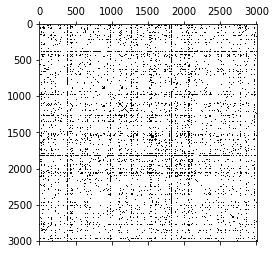

frequency table of bigrams of CNN csv (ordered by alphanumeric order) 

            a  abandon  ability  able  ...  zero  zhejiang  zone  zoo
a         9.0      0.0      0.0   0.0  ...   0.0       0.0   0.0  0.0
abandon   0.0      0.0      0.0   0.0  ...   2.0       0.0   0.0  0.0
ability   0.0      0.0      0.0   0.0  ...   0.0       0.0   0.0  0.0
able      0.0      0.0      0.0   0.0  ...   0.0       0.0   0.0  0.0
aboard    0.0      0.0      0.0   0.0  ...   0.0       0.0   0.0  0.0
...       ...      ...      ...   ...  ...   ...       ...   ...  ...
yunnan    0.0      0.0      0.0   0.0  ...   0.0       0.0   0.0  0.0
zero      0.0      2.0      0.0   0.0  ...   1.0       0.0   0.0  0.0
zhejiang  0.0      0.0      0.0   0.0  ...   0.0       2.0   0.0  0.0
zone      0.0      0.0      0.0   0.0  ...   0.0       0.0   0.0  0.0
zoo       0.0      0.0      0.0   0.0  ...   0.0       0.0   0.0  0.0

[3009 rows x 3009 columns]


In [254]:
print('spy plot of the adjacency matrix\n')
plt.spy(A)
plt.show()
print('=====================================\nfrequency table of bigrams of CNN csv (ordered by alphanumeric order) \n')
print(A)

In [255]:
# Constructing the graph object from the adjacency matrix

G = nx.convert_matrix.from_numpy_array(A.to_numpy())
G = nx.relabel_nodes(G , mapping = dict([ (i,sorted(list(freq_dict.keys()))[i]) for i in range(len(freq_dict.keys())) ]) ) 
print('is connected: ',nx.is_connected(G))

is connected:  True


In [256]:
filename = "./edgelist.csv"
nx.write_weighted_edgelist(G, filename, delimiter=",")
#add header with appropriate column names
!sed -i.bak 1i"Source,Target,Weight" ./edgelist.csv

word_nodes = pd.DataFrame.from_dict(freq_dict,orient="index")
word_nodes
word_nodes.reset_index(inplace=True)
word_nodes["Label"] = word_nodes["index"]
word_nodes.rename(columns={"index":"Id",0:"delete"},inplace=True)
word_nodes = word_nodes.drop(columns=['delete'])

word_nodes

,Id,Label
0,covid,covid
1,china,china
2,coronavirus,coronavirus
3,vaccine,vaccine
4,say,say
...,...,...
3004,al,al
3005,bi,bi
3006,d,d
3007,tinue,tinue


In [259]:
files.download("edgelist.csv")
files.download("edgelist.csv.bak")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Pagerank

In [260]:
# Calculating the pagerank on graph G, teleportation probability here is 0.15 but since the graph is strongly connected we can set it to zero if we want
pr = nx.algorithms.pagerank(G,alpha = 1)
pr = dict(sorted(pr.items(), key=lambda item: item[1],reverse  = True))

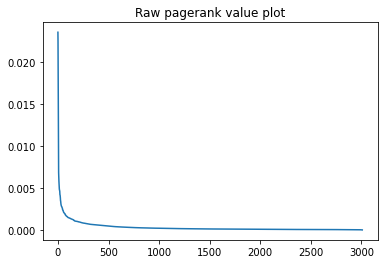

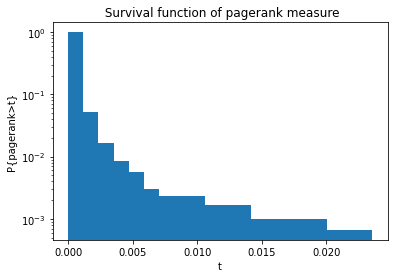

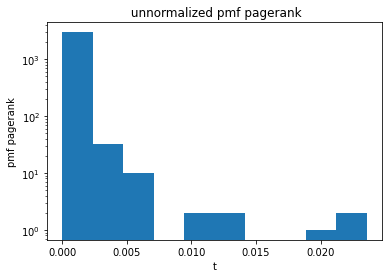

In [261]:
plt.plot(list(pr.values()))
plt.title('Raw pagerank value plot')
plt.show()

print('\n=================================================')

plt.hist(list(pr.values()),log = True,cumulative=-1 ,bins = 20,density  = True)
plt.xlabel('t')
plt.ylabel('P{pagerank>t}')
plt.title(' Survival function of pagerank measure')
plt.show()

print('\n=================================================')

plt.hist(list(pr.values()),log = True ,cumulative = 0 )
plt.xlabel('t')
plt.ylabel('pmf pagerank')
plt.title(' unnormalized pmf pagerank')
plt.show()

With this plot we can filtrate out meaningful words by choosing a threshold on the pagerank. As a tentative, we filter out by thresholding at the last step, so we take only words with a pagerank value > 0.020

In [262]:
def threshold(vector,threshold):

  l = [(el,vector[el]) for el in vector if vector[el] >= threshold ]

  print(pd.DataFrame(l))

  return 

In [267]:
threshold(pr,0.003)

              0         1
0         covid  0.023556
1         china  0.022452
2   coronavirus  0.019498
3           say  0.013620
4       vaccine  0.013159
5          case  0.009707
6           new  0.009650
7      outbreak  0.006829
8        people  0.006305
9     president  0.005823
10       health  0.005789
11        trump  0.005533
12       report  0.005370
13        virus  0.005166
14         test  0.004860
15        death  0.004803
16      country  0.004769
17          day  0.004669
18        first  0.004617
19        novel  0.004349
20     hospital  0.004182
21        world  0.004162
22         year  0.004109
23     pandemic  0.003985
24        state  0.003839
25       spread  0.003544
26      million  0.003464
27         city  0.003452
28          one  0.003258
29      patient  0.003083
30     official  0.003066
31      johnson  0.003005
32         take  0.003001


### TF-IDF

In [268]:
tfidf = TfidfVectorizer(ngram_range=(1,1))   # ngram range can be changed to obtain measures regarding n grams instead of single words

X = tfidf.fit_transform(cleaned_mostfreq_China_USA_text).toarray()    # entry (i,j) if Tfidf measure of word_list[j] in document i

word_list = tfidf.get_feature_names_out()

In [269]:
tfidf_df = pd.DataFrame(X,columns = word_list)

tfidf_df

,abandon,ability,able,aboard,abroad,absolutely,abundance,abuse,academic,academy,accelerate,accept,access,accommodate,accord,account,accountable,accurate,accusation,accuse,achieve,achievement,acid,across,act,action,activate,active,actively,activist,activity,actually,adapt,add,addiction,additional,address,adjust,administer,administration,...,woman,wonder,wooden,word,work,worker,working,workplace,world,worried,worrisome,worry,worrying,worsen,worst,worth,would,write,wrong,xenophobia,xinhua,xinjiang,yang,year,yellow,yen,yes,yesterday,yet,yield,yoga,york,young,youth,yuan,yunnan,zero,zhejiang,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.178397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.274656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.178678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.346939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,

In [270]:
tfidf_word_measure = np.mean(tfidf_df,axis = 0)

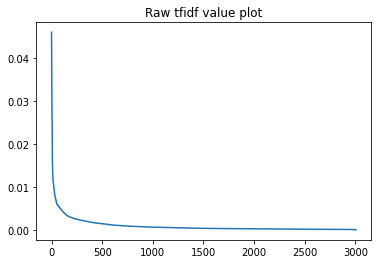

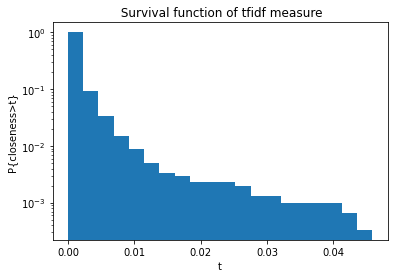

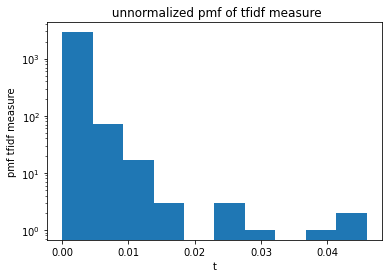

In [276]:
plt.plot(sorted(list(tfidf_word_measure),reverse = True))
plt.title('Raw tfidf value plot')
plt.show()

print('\n=================================================')

plt.hist(list(tfidf_word_measure),log = True,cumulative=-1 ,bins = 20,density  = True)
plt.xlabel('t')
plt.ylabel('P{closeness>t}')
plt.title(' Survival function of tfidf measure')
plt.show()

print('\n=================================================')

plt.hist(list(tfidf_word_measure),log = True ,cumulative = 0 )
plt.xlabel('t')
plt.ylabel('pmf tfidf measure')
plt.title(' unnormalized pmf of tfidf measure')
plt.show()

In [280]:
tfidf_word_measure = tfidf_word_measure.sort_values(ascending = False)
tfidf_word_measure[0:30]

covid          0.045907
china          0.042352
coronavirus    0.041014
vaccine        0.031511
case           0.027304
say            0.025521
new            0.025055
report         0.016750
outbreak       0.016235
death          0.015669
people         0.013179
virus          0.013160
test           0.013013
health         0.012427
first          0.011718
hospital       0.011368
day            0.011146
novel          0.011085
spread         0.010968
million        0.010898
country        0.010705
president      0.010656
late           0.010173
trump          0.009704
state          0.009506
world          0.009401
confirm        0.009307
infection      0.009175
rise           0.008717
patient        0.008580
dtype: float64